<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from https://chatgpt.com/c/67a6f8e8-31cc-800e-b227-052ea4820b5e

In [ ]:
!pip install gymnasium[atari] ale-py

In [ ]:
import gymnasium as gym
env_specs = gym.registry.keys()
print(list(env_specs))


['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5', 'Humano

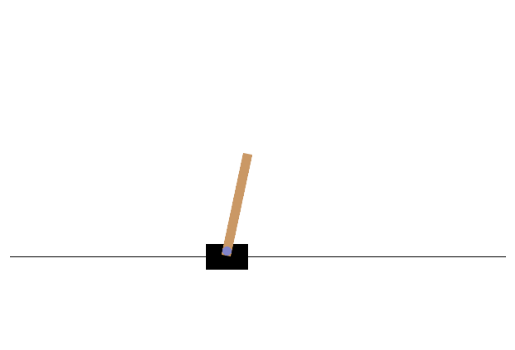

In [ ]:
# import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 创建 CartPole 环境
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0]  # 状态维度
action_size = env.action_space.n  # 动作数量

# 超参数
gamma = 0.99  # 折扣因子
epsilon = 1.0  # 初始探索率
epsilon_min = 0.1
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 32
memory_size = 10000
target_update_freq = 10  # 目标网络更新频率
episodes = 500  # 训练回合数

# 经验回放缓冲区
memory = deque(maxlen=memory_size)

# 记录奖励
reward_history = []

# DQN 网络
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(24, activation='relu', input_shape=(state_size,)),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# 初始化网络
model = build_model()
target_model = build_model()
target_model.set_weights(model.get_weights())  # 复制初始权重

# 画图函数
def plot_frame(frame):
    plt.imshow(frame)
    plt.axis("off")
    display(plt.gcf())
    clear_output(wait=True)

# 训练 DQN
for episode in range(episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    for step in range(500):  # CartPole-v1 最多 500 步
        # 选择动作（ε-贪心）
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values[0])

        # 采取动作
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # 存储经验
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # 渲染并可视化
        frame = env.render()
        plot_frame(frame)

        if done:
            break

    reward_history.append(total_reward)  # 记录每轮奖励

    print(f"Episode {episode}, Total Reward: {total_reward}")

    # 经验回放训练
    if len(memory) > batch_size:
        minibatch = random.sample(memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target_q = model.predict(state, verbose=0)
            if done:
                target_q[0][action] = reward
            else:
                future_q = np.max(target_model.predict(next_state, verbose=0))
                target_q[0][action] = reward + gamma * future_q
            model.fit(state, target_q, epochs=1, verbose=0)

    # 目标网络更新
    if episode % target_update_freq == 0:
        target_model.set_weights(model.get_weights())

    # 探索率衰减
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

env.close()  # 训练完成后关闭环境

# 绘制奖励趋势图
plt.figure(figsize=(10, 5))
plt.plot(reward_history, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("CartPole DQN Learning Progress")
plt.legend()
plt.grid()
plt.show()